In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [14]:
df = pd.read_csv('behavior data integrated/Bhv 8 - Cask/M3/FR1/FED000_071723_03.CSV')

data_droped = df[['MM:DD:YYYY hh:mm:ss', 'Event', 'Active_Poke']].rename(
    columns={'MM:DD:YYYY hh:mm:ss': 'Time_Stamp'})
data_droped = data_droped.replace({'LeftWithPellet': 'Left', 'LeftDuringDispense': 'Left',
                                   'RightWithPellet': 'Right', 'RightDuringDispense': 'Right'})


In [15]:
data_droped['Time_Stamp'] = pd.to_datetime(data_droped['Time_Stamp'])

In [16]:
type(data_droped.Time_Stamp[0])

pandas._libs.tslibs.timestamps.Timestamp

In [17]:
# Group data by every 4 hours and calculate correct rate
result = data_droped.groupby(pd.Grouper(key='Time_Stamp', freq='2H')).apply(lambda group: (
    group['Event'] == group['Active_Poke']).sum() / group['Event'].isin(['Left', 'Right']).sum()).reset_index()

# Rename columns for clarity
result.columns = ['Time_Stamp', 'Correct_Rate']

In [18]:
result.dropna(inplace=True, axis='index')

In [19]:
result = result[2:]

In [20]:
from scipy.optimize import curve_fit
from datetime import datetime, timedelta

def sigmoid(x, L, x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

result['Time_Stamp'] = result['Time_Stamp'].apply(lambda x: x.timestamp())
median_time_stamp = result['Time_Stamp'].median()

p0 = [max(result['Correct_Rate']), median_time_stamp, min(result['Time_Stamp']), min(
    result['Correct_Rate'])]  # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, result['Time_Stamp'], result['Correct_Rate'], p0, method='dogbox')

L, x0, k, b = popt

print("Optimal Parameters:")
print(f"L = {L}")
print(f"x0 = {x0}")
print(f"k = {k}")
print(f"b = {b}")
print(datetime.fromtimestamp(x0))

Optimal Parameters:
L = 0.09094556094556061
x0 = 1689631199.8406222
k = 1689595200.0
b = 0.9013621313621316
2023-07-17 14:59:59.840622


/Users/yaomingyang/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
y_values = sigmoid(result['Time_Stamp'], L, x0, k, b)

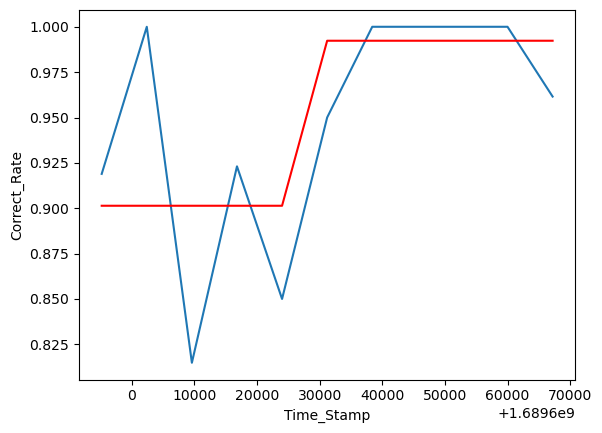

In [22]:
sns.lineplot(data=result, x='Time_Stamp', y='Correct_Rate')
sns.lineplot(x=result['Time_Stamp'], y=y_values, color='red')
plt.show()